# Movies Recommender (Spoiler Free Reviews)

In [3]:
# !pip install vaderSentiment
# !pip install scattertext
# !pip install flair

In [1]:
import gensim.downloader as api
import scattertext as st
import numpy as np
import pandas as pd
import json
import nltk
import re
import random
import string
import pickle
import spacy
import vaderSentiment
import csv
import gensim

from sklearn import metrics
# from google.colab import drive
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
# from wordcloud import WordCloud
from textblob import TextBlob
from scipy.linalg import svd
from tqdm import tqdm
from gensim import corpora, models, similarities, matutils
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from flair.models import TextClassifier
# from flair.data import Sentence
from collections import defaultdict
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer, wordnet
from nltk.tokenize import TreebankWordTokenizer, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_details = pd.read_json('IMDB_movie_details.json', lines=True)
df_reviews = pd.read_json('IMDB_reviews.json', lines=True)

In [9]:
df_reviews.head(2)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.


In [10]:
df_details.head(2)

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...


# EDA

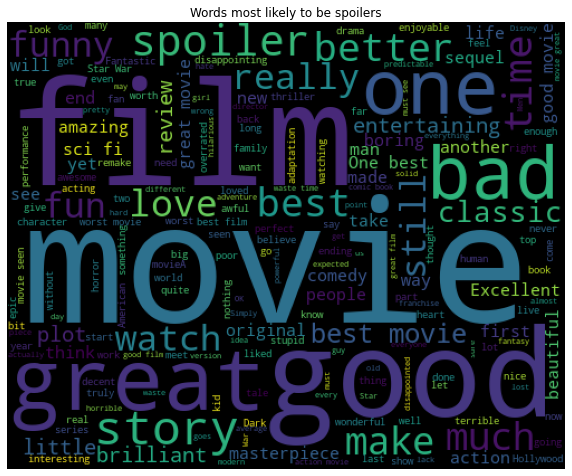

In [11]:
# This figure shows the most common words in the spoiler reviews in the df_reviews 
x = df_reviews[df_reviews['is_spoiler']==True]
words = x['review_summary'][~pd.isnull(x['review_summary'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))
plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Words most likely to be spoilers')
plt.imshow(wordcloud)
plt.show()

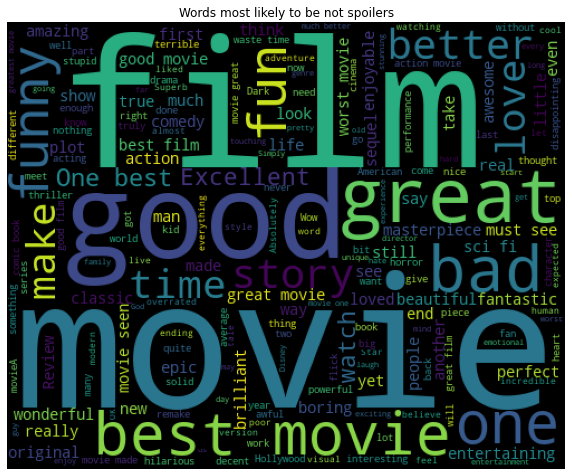

In [12]:
# This figure shows the most common words in the non-spoiler reviews in the df_reviews 
x = df_reviews[df_reviews['is_spoiler']==False]
words = x['review_summary'][~pd.isnull(x['review_summary'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))
plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Words most likely to be not spoilers')
plt.imshow(wordcloud)
plt.show()

In [13]:
# Scattertext Explorer plot can be found in the scatter_text.html file.


# corpus = st.CorpusFromPandas(df_reviews,
#                              category_col='is_spoiler',
#                              text_col='review_summary',
#                              nlp=st.whitespace_nlp_with_sentences).build()
# html = st.produce_scattertext_explorer(
#        corpus,
#        category='1',
#        category_name='Spoiler',
#        not_category_name='Not Spoiler',
#        minimum_term_frequency=1,
#        pmi_threshold_coefficient=5,
#        width_in_pixels=1000,
#        metadata=df_reviews['movie_id'].astype(str)
#        )
# open('scatter_text.html', 'wb').write(html.encode('utf-8'));

Text(0, 0.5, 'Number of Reviews')

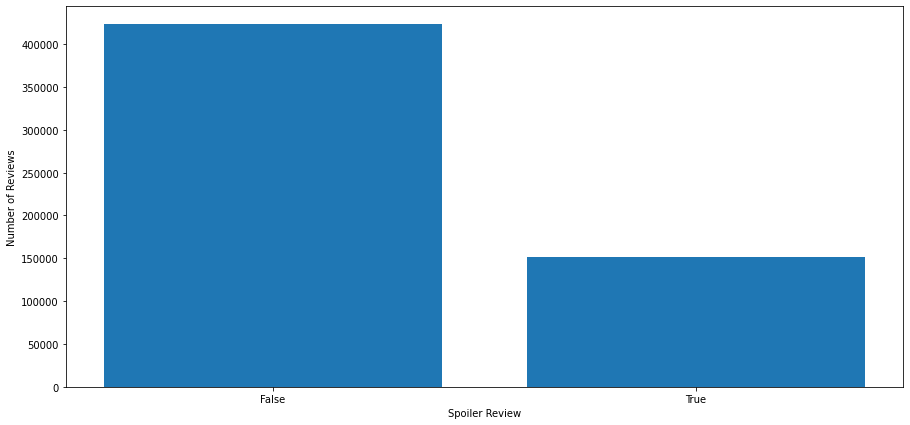

In [15]:
# This plot shows the amount of reviews we have labeled as Spoiler compared to non-spoiler.
plt.figure(figsize=(15,7))
plt.bar(df_reviews.is_spoiler.astype(str).value_counts().index, df_reviews.is_spoiler.astype(str).value_counts());
plt.xlabel('Spoiler Review')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Movies')

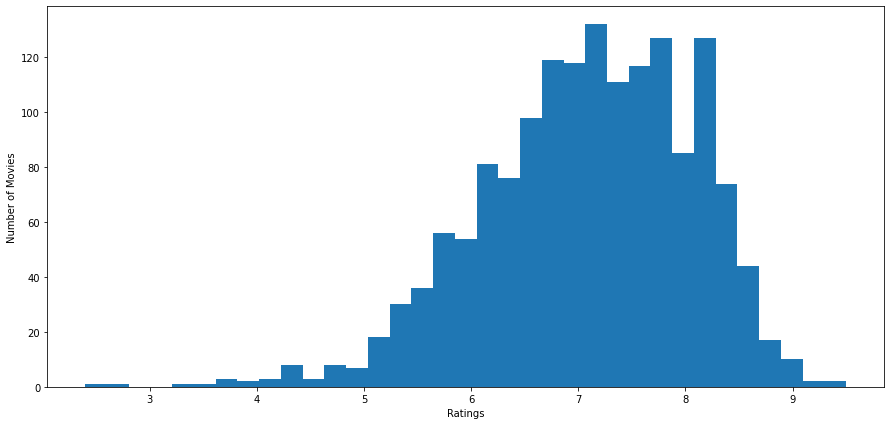

In [16]:
# Histogram shows the distribution of movies ratings.
plt.figure(figsize=(15,7))
plt.hist(df_details.rating, bins=35);
plt.xlabel('Ratings')
plt.ylabel('Number of Movies')

Before we move forward, we need to downsample our data due to computation time and capacity.

In [17]:
# Downsampling
df_reviews = pd.concat([df_reviews[df_reviews.is_spoiler == True].sample(50000),
                        df_reviews[df_reviews.is_spoiler == False].sample(50000)]).reset_index(drop=True)

# Sentiment Analysis

In this part, We will find positive and negative reviews from the texts and consider only positive in further experiments.

We used two ways to perform the sentimate analysis: Vader and Flair. Although Flair is more accurate, but it takes too much time to run. And since we are limited in time, we will use Vader.

## Vader

In [20]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [19]:
df_reviews.head(2)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,16 March 2008,tt0290334,ur17571044,True,X-Men is my favourite Comic Book Series and I ...,10,My favourite comic-book conversion
1,17 November 2007,tt0418279,ur8579674,True,It's like a five-year-old wrote a script while...,1,Porn


In [21]:
df_reviews['scores_text_vader'] = df_reviews['review_text'].apply(lambda review: analyser.polarity_scores(review))

In [22]:
df_reviews['compound_text_vader']  = df_reviews['scores_text_vader'].apply(lambda score_dict: score_dict['compound'])

In [23]:
df_reviews['scores_summ_vader'] = df_reviews['review_summary'].apply(lambda review: analyser.polarity_scores(review))

In [24]:
df_reviews['compound_summ_vader']  = df_reviews['scores_summ_vader'].apply(lambda score_dict: score_dict['compound'])

In [25]:
def Sentimnt(x):
    if x>= 0.05:
        return "Positive"
    elif x<= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_reviews['Sentiment_text'] = df_reviews['compound_text_vader'].apply(Sentimnt)
df_reviews['Sentiment_summ'] = df_reviews['compound_summ_vader'].apply(Sentimnt)

In [28]:
df_reviews.head(15)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,scores_text_vader,compound_text_vader,scores_summ_vader,compound_summ_vader,Sentiment_text,Sentiment_summ
0,16 March 2008,tt0290334,ur17571044,True,X-Men is my favourite Comic Book Series and I ...,10,My favourite comic-book conversion,"{'neg': 0.106, 'neu': 0.75, 'pos': 0.143, 'com...",0.9658,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Positive,Neutral
1,17 November 2007,tt0418279,ur8579674,True,It's like a five-year-old wrote a script while...,1,Porn,"{'neg': 0.085, 'neu': 0.849, 'pos': 0.067, 'co...",-0.9040,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,Neutral
2,29 November 2012,tt0454876,ur24259348,True,"The whole story was boring, was hard to be cap...",1,I hated it,"{'neg': 0.212, 'neu': 0.713, 'pos': 0.076, 'co...",-0.9822,"{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'comp...",-0.6369,Negative,Negative
3,30 June 2010,tt1325004,ur23058393,True,It's one thing if you don't like the storyline...,10,Way better than New Moon,"{'neg': 0.07, 'neu': 0.835, 'pos': 0.095, 'com...",0.9459,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.4404,Positive,Positive
4,11 June 2017,tt1837492,ur55075308,True,I don't understand why people like this show s...,3,Garbage. Plain and Simple,"{'neg': 0.15, 'neu': 0.725, 'pos': 0.125, 'com...",-0.9789,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,Neutral
5,7 April 2006,tt0095016,ur10102549,True,"If you have not seen Die Hard, not only is the...",10,Bruce Willis at his best!,"{'neg': 0.187, 'neu': 0.585, 'pos': 0.228, 'co...",0.8845,"{'neg': 0.0, 'neu': 0.471, 'pos': 0.529, 'comp...",0.6696,Positive,Positive
6,25 November 2009,tt0898367,ur10631863,True,"I would say that I liked this movie ""alright""....",6,Decent Post Apocalyptic Film From A different ...,"{'neg': 0.082, 'neu': 0.811, 'pos': 0.107, 'co...",0.4224,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp...",-0.6597,Positive,Negative
7,26 March 2016,tt2975590,ur27583389,True,"Let me start with saying, if asked, I identify...",9,Pleasantly Surprised,"{'neg': 0.043, 'neu': 0.769, 'pos': 0.188, 'co...",0.9973,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.6124,Positive,Positive
8,8 February 2007,tt0206634,ur6995847,True,My summary says it all. The movie is about a g...,3,Tedious plot well filmed,"{'neg': 0.138, 'neu': 0.79, 'pos': 0.073, 'com...",-0.6445,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.2732,Negative,Positive
9,31 August 2016,tt2582782,ur66341442,True,I thoroughly enjoyed Hell or High Water.A mode...,9,Myth and the Mundane,"{'neg': 0.119, 'neu': 0.764, 'pos': 0.117, 'co...",-0.7039,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,Neutral


We can see that there might be some differences between the results in review text and summary. We will solve this issue by comparing the compound score.

In [29]:
if abs(df_reviews['compound_text_vader']).all() >= abs(df_reviews['compound_summ_vader']).all():
    df_reviews['vader_final_sent'] = df_reviews['Sentiment_text']
else:
    df_reviews['vader_final_sent'] = df_reviews['Sentiment_summ']

In [32]:
df_reviews = df_reviews[df_reviews.vader_final_sent == 'Positive'][['movie_id','user_id','is_spoiler','review_text','review_summary']].reset_index(drop=True)

In [33]:
# Save it in case RAM crashed
df_reviews.to_csv('/content/drive/MyDrive/df_reviews.csv')

## Flair

In [ ]:
# classifier = TextClassifier.load('en-sentiment')
# def sentiment_analyzer_score(docu):
#     sentence = Sentence(docu)
#     classifier.predict(sentence)
#     return sentence.labels

In [ ]:
# df_reviews['Flair_scores_text'] = df_reviews['review_text'].apply(lambda review: sentiment_analyzer_score(review))

In [ ]:
# df_reviews['Flair_sentiment'] = df_reviews.Flair_scores_text.apply(lambda review: str(review[0]).split()[0])

In [ ]:
# df_reviews['Flair_score'] = df_reviews.Flair_scores_text.apply(lambda review: float(str(review[0]).split()[1].strip('()')))

In [ ]:
# df_reviews.head()

# Data Cleaning 

In [35]:
# We will drop the columns that won't benefit us 
df_details.drop(['duration','genre','rating','release_date'], axis=1, inplace = True)

In [ ]:
# # We won't need this. We need the movies ids in its original format
# cleaned_movieID = []
# for i in df_details.movie_id:
#     emp_str = ''
#     for ii in i:
#         if ii.isdigit():
#             emp_str+=ii
#     cleaned_movieID.append(emp_str)
# df_details['movie_id'] = cleaned_movieID

In [ ]:
# cleaned = []
# for i in df_reviews.movie_id:
#     emp_str = ''
#     for ii in i:
#         if ii.isdigit():
#             emp_str+=ii
#     cleaned.append(emp_str)
# df_reviews['movie_id'] = cleaned

In [ ]:
# cleaned = []
# for i in df_reviews.user_id:
#     emp_str = ''
#     for ii in i:
#         if ii.isdigit():
#             emp_str+=ii
#     cleaned.append(emp_str)
# df_reviews['user_id'] = cleaned

In [36]:
df_reviews.is_spoiler.replace(True, 1, inplace=True)
df_reviews['is_spoiler'] = df_reviews.is_spoiler.astype(int)

In [37]:
df_reviews.head(2)

,movie_id,user_id,is_spoiler,review_text,review_summary
0,tt0290334,ur17571044,1,X-Men is my favourite Comic Book Series and I ...,My favourite comic-book conversion
1,tt1325004,ur23058393,1,It's one thing if you don't like the storyline...,Way better than New Moon


In [38]:
df_details.head(2)

,movie_id,plot_summary,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...","Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",Four boys around the age of 10 are friends in ...


In [39]:
df_reviews.fillna('Missing', inplace=True)
df_details.fillna('Missing', inplace=True)

In [40]:
df_reviews.to_csv('/content/drive/MyDrive/df_reviews.csv')
df_details.to_csv('/content/drive/MyDrive/df_details.csv')

NLP Preproccessing

In [41]:
# We created a cleaning finction that uses lemmatization to get original word
def data_cleaning(data, lemmatizer=WordNetLemmatizer()):
    list_of_sent = []
    stop_words = stopwords.words('english')
    stop_words.extend(["movie", "film", "story", "write", "life"])
    for a_row in tqdm(data.values):
        a_row = re.sub('[%s]' %re.escape(string.punctuation),'',re.sub('\w*\d\w*','', a_row)).lower().split(' ') # remove all punctuations
        clean_row = ''
        for a_word in a_row:
            if a_word.isalpha() and a_word not in stopwords.words('english'):
                if lemmatizer:
                    a_word = lemmatizer.lemmatize(a_word, pos='a')
                    a_word = lemmatizer.lemmatize(a_word, pos='s')
                    a_word = lemmatizer.lemmatize(a_word, pos='r')
                    a_word = lemmatizer.lemmatize(a_word, pos='n')
                    a_word = lemmatizer.lemmatize(a_word, pos='v')
                clean_row = clean_row + ' ' + a_word
        list_of_sent.append(clean_row.strip())
    return list_of_sent

In [42]:
# We will apply the cleaning function to out text data
df_details['plot_summary'] = data_cleaning(df_details['plot_summary'])
df_details['plot_synopsis'] = data_cleaning(df_details['plot_synopsis'])

100%|██████████| 1572/1572 [05:07<00:00,  5.11it/s]


In [43]:
df_reviews['review_summary'] = data_cleaning(df_reviews['review_summary'])
df_reviews['review_text'] = data_cleaning(df_reviews['review_text'])

100%|██████████| 75535/75535 [48:16<00:00, 26.08it/s]


In [44]:
df_reviews.head(2)

,movie_id,user_id,is_spoiler,review_text,review_summary
0,tt0290334,ur17571044,1,xmen favourite comic book series love make sil...,favourite comicbook conversion
1,tt1325004,ur23058393,1,one thing dont like storyline begin teen super...,way good new moon


In [45]:
df_details.head(2)

,movie_id,plot_summary,plot_synopsis
0,tt0105112,former cia analyst jack ryan england family va...,jack ryan ford work vacation london family ret...
1,tt1204975,billy michael douglas paddy robert de niro arc...,four boy around age friend brooklyn nickname f...


In [46]:
# df_details.fillna('Missing', inplace=True)
# df_reviews.fillna('Missing', inplace=True)

In [47]:
# Download as a backup
df_reviews.to_json('/content/drive/MyDrive/df_reviews.json')
df_details.to_json('/content/drive/MyDrive/df_details.json')

# Read Cleaned Data

In [8]:
df_reviews = pd.read_json('/content/drive/MyDrive/df_reviews.json')

In [7]:
df_details = pd.read_json('/content/drive/MyDrive/df_details.json')

In [49]:
# df_details.fillna('Missing', inplace=True)
# df_reviews.fillna('Missing', inplace=True)

In [50]:
df_reviews.head(2)

,movie_id,user_id,is_spoiler,review_text,review_summary
0,tt0290334,ur17571044,1,xmen favourite comic book series love make sil...,favourite comicbook conversion
1,tt1325004,ur23058393,1,one thing dont like storyline begin teen super...,way good new moon


In [51]:
df_details.head(2)

,movie_id,plot_summary,plot_synopsis
0,tt0105112,former cia analyst jack ryan england family va...,jack ryan ford work vacation london family ret...
1,tt1204975,billy michael douglas paddy robert de niro arc...,four boy around age friend brooklyn nickname f...


# Finding Spoilers

In [65]:
df_reviews = pd.read_json('df_reviews.json')
df_details = pd.read_json('df_details.json')
# Downsampling
df_reviews = pd.concat([df_reviews[df_reviews.is_spoiler == True].sample(2500),
                        df_reviews[df_reviews.is_spoiler == False].sample(2500)]).reset_index(drop=True)

## COS Similarities

We'll try to find spoilers using many ways, but first by using cosine similarities.

In [66]:
def cos_sim(plots,reviews):
    output = []
    for review in tqdm(reviews.values):
        a_row = []
        for a_plot in plots.values:
            a_row.append(np.dot(review, a_plot)/(np.linalg.norm(review)*np.linalg.norm(a_plot)))
        output.append(a_row)
    return output

In [67]:
def get_cos_sim(cos_sim_):
    num=0
    dumm_list_ = []
    for x in df_reviews.movie_id:
        dumm_list_.append(cos_sim_.loc[num,x])
        num+=1
    return dumm_list_

### Using TfidfVectorizer

Using 'plot_synopsis' that contains the complete plot compared with the complete and the summarized reviews.

In [68]:
vectorizer = TfidfVectorizer(decode_error='ignore', max_features=2000)
tfidf_plot_synopsis = vectorizer.fit_transform(df_details.plot_synopsis)
tfidf_review_text = vectorizer.transform(df_reviews.review_text)
tfidf_review_summary = vectorizer.transform(df_reviews.review_summary)

In [69]:
tfidf_plot_synopsis = pd.DataFrame(tfidf_plot_synopsis.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_text = pd.DataFrame(tfidf_review_text.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_summary = pd.DataFrame(tfidf_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [70]:
cos_sim_tfidf_plot_synopsis_review_text = pd.DataFrame(cos_sim(tfidf_plot_synopsis,tfidf_review_text), columns = df_details.movie_id.values)
cos_sim_tfidf_plot_synopsis_review_summary = pd.DataFrame(cos_sim(tfidf_plot_synopsis,tfidf_review_summary), columns = df_details.movie_id.values)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]<ipython-input-66-2eb67f9709d8>:6: RuntimeWarning: invalid value encountered in double_scalars
  a_row.append(np.dot(review, a_plot)/(np.linalg.norm(review)*np.linalg.norm(a_plot)))
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.42it/s]


In [28]:
cos_sim_tfidf_plot_synopsis_review_text.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_text.json')
cos_sim_tfidf_plot_synopsis_review_summary.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_summary.json')

In [ ]:
cos_sim_tfidf_plot_synopsis_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_text.json')
cos_sim_tfidf_plot_synopsis_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_summary.json')

Now we will use 'plot_summary' that contains the plot's summary only.

In [71]:
tfidf_plot_summary = vectorizer.fit_transform(df_details.plot_summary)
tfidf_review_text = vectorizer.transform(df_reviews.review_text)
tfidf_review_summary = vectorizer.transform(df_reviews.review_summary)

In [72]:
tfidf_plot_summary = pd.DataFrame(tfidf_plot_summary.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_text = pd.DataFrame(tfidf_review_text.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_summary = pd.DataFrame(tfidf_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [73]:
cos_sim_tfidf_plot_summary_review_text = pd.DataFrame(cos_sim(tfidf_plot_summary,tfidf_review_text), columns = df_details.movie_id.values)
cos_sim_tfidf_plot_summary_review_summary = pd.DataFrame(cos_sim(tfidf_plot_summary,tfidf_review_summary), columns = df_details.movie_id.values)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]<ipython-input-66-2eb67f9709d8>:6: RuntimeWarning: invalid value encountered in double_scalars
  a_row.append(np.dot(review, a_plot)/(np.linalg.norm(review)*np.linalg.norm(a_plot)))
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.60it/s]


In [ ]:
cos_sim_tfidf_plot_summary_review_text.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_text.json')
cos_sim_tfidf_plot_summary_review_summary.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_summary.json')

In [ ]:
cos_sim_tfidf_plot_summary_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_text.json')
cos_sim_tfidf_plot_summary_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_summary.json')

We'll now try to find a way to discriminate between the spoiler reviews and the non-spoiler ones.

In [74]:
df_reviews['tfidf_plotsyn_revtxt'] = get_cos_sim(cos_sim_tfidf_plot_synopsis_review_text.fillna(0))
df_reviews['tfidf_plotsyn_revsum'] = get_cos_sim(cos_sim_tfidf_plot_synopsis_review_summary.fillna(0))
df_reviews['tfidf_plotsum_revtxt'] = get_cos_sim(cos_sim_tfidf_plot_summary_review_text.fillna(0))
df_reviews['tfidf_plotsum_revsum'] = get_cos_sim(cos_sim_tfidf_plot_summary_review_summary.fillna(0))

In [ ]:
df_reviews.to_json('/content/drive/MyDrive/df_reviews.json')

In [ ]:
df_reviews = pd.read_json('/content/drive/MyDrive/df_reviews.json')

In [75]:
df_reviews.head(2)

,movie_id,user_id,is_spoiler,review_text,review_summary,tfidf_plotsyn_revtxt,tfidf_plotsyn_revsum,tfidf_plotsum_revtxt,tfidf_plotsum_revsum
0,tt0251127,ur5118137,1,wait movie come video although sound somewhat ...,couldnt believe actually like movie,0.00000,0.000000,0.045928,0.00000
1,tt0108399,ur3712755,1,like true romance story cool funny scene make ...,fun watch possible spoiler,0.14083,0.011572,0.285808,0.11323


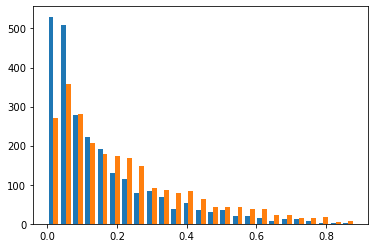

In [159]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['tfidf_plotsyn_revtxt'],
         df_reviews[df_reviews.is_spoiler == 1]['tfidf_plotsyn_revtxt']], bins=25);

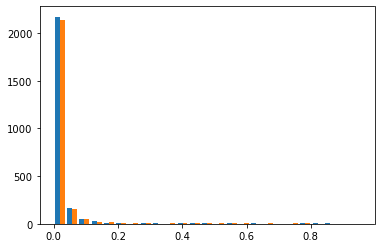

In [161]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['tfidf_plotsyn_revsum'],
          df_reviews[df_reviews.is_spoiler == 1]['tfidf_plotsyn_revsum']], bins=25);

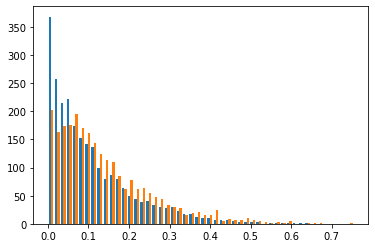

In [162]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['tfidf_plotsum_revtxt'],
         df_reviews[df_reviews.is_spoiler == 1]['tfidf_plotsum_revtxt']], bins=50);

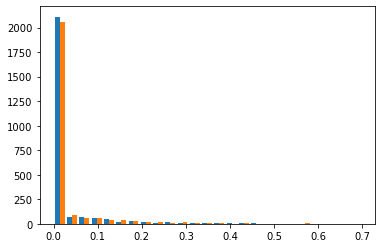

In [164]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['tfidf_plotsum_revsum'],
         df_reviews[df_reviews.is_spoiler == 1]['tfidf_plotsum_revsum']], bins=25);

### Using CountVectorizer

Here we will do the exact same thing we did for the tfidf vectorizer above, but by using CountVectorizer.

plot_synopsis

In [78]:
vectorizer = CountVectorizer(decode_error='ignore', max_features=2000)
cv_plot_synopsis = vectorizer.fit_transform(df_details.plot_synopsis)
cv_review_text = vectorizer.transform(df_reviews.review_text)
cv_review_summary = vectorizer.transform(df_reviews.review_summary)

In [79]:
cv_plot_synopsis = pd.DataFrame(cv_plot_synopsis.toarray(), columns=vectorizer.get_feature_names())
cv_review_text = pd.DataFrame(cv_review_text.toarray(), columns=vectorizer.get_feature_names())
cv_review_summary = pd.DataFrame(cv_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [80]:
cos_sim_cv_plot_synopsis_review_text = pd.DataFrame(cos_sim(cv_plot_synopsis,cv_review_text), columns = df_details.movie_id.values)
cos_sim_cv_plot_synopsis_review_summary = pd.DataFrame(cos_sim(cv_plot_synopsis,cv_review_summary), columns = df_details.movie_id.values)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]<ipython-input-66-2eb67f9709d8>:6: RuntimeWarning: invalid value encountered in true_divide
  a_row.append(np.dot(review, a_plot)/(np.linalg.norm(review)*np.linalg.norm(a_plot)))
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:36<00:00, 31.93it/s]


In [ ]:
cos_sim_cv_plot_synopsis_review_text.to_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_text.json')
cos_sim_cv_plot_synopsis_review_summary.to_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_summary.json')

In [ ]:
cos_sim_cv_plot_synopsis_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_text.json')
cos_sim_cv_plot_synopsis_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_summary.json')

plot_summary

In [81]:
cv_plot_summary = vectorizer.fit_transform(df_details.plot_summary)
cv_review_text = vectorizer.transform(df_reviews.review_text)
cv_review_summary = vectorizer.transform(df_reviews.review_summary)

In [82]:
cv_plot_summary = pd.DataFrame(cv_plot_summary.toarray(), columns=vectorizer.get_feature_names())
cv_review_text = pd.DataFrame(cv_review_text.toarray(), columns=vectorizer.get_feature_names())
cv_review_summary = pd.DataFrame(cv_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [83]:
cos_sim_cv_plot_summary_review_text = pd.DataFrame(cos_sim(cv_plot_summary,cv_review_text), columns = df_details.movie_id.values)
cos_sim_cv_plot_summary_review_summary = pd.DataFrame(cos_sim(cv_plot_summary,cv_review_summary), columns = df_details.movie_id.values)

  0%|                                                                                 | 4/5000 [00:00<02:31, 32.87it/s]<ipython-input-66-2eb67f9709d8>:6: RuntimeWarning: invalid value encountered in true_divide
  a_row.append(np.dot(review, a_plot)/(np.linalg.norm(review)*np.linalg.norm(a_plot)))
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:39<00:00, 31.40it/s]


In [ ]:
cos_sim_cv_plot_summary_review_text.to_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_text.json')
cos_sim_cv_plot_summary_review_summary.to_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_summary.json')

In [ ]:
cos_sim_cv_plot_summary_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_text.json')
cos_sim_cv_plot_summary_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_summary.json')

In [84]:
df_reviews['cv_plotsyn_revtxt'] = get_cos_sim(cos_sim_cv_plot_synopsis_review_text)
df_reviews['cv_plotsyn_revsum'] = get_cos_sim(cos_sim_cv_plot_synopsis_review_summary)
df_reviews['cv_plotsum_revtxt'] = get_cos_sim(cos_sim_cv_plot_summary_review_text)
df_reviews['cv_plotsum_revsum'] = get_cos_sim(cos_sim_cv_plot_summary_review_summary)

In [85]:
df_reviews.head(2)

,movie_id,user_id,is_spoiler,review_text,review_summary,tfidf_plotsyn_revtxt,tfidf_plotsyn_revsum,tfidf_plotsum_revtxt,tfidf_plotsum_revsum,cv_plotsyn_revtxt,cv_plotsyn_revsum,cv_plotsum_revtxt,cv_plotsum_revsum
0,tt0251127,ur5118137,1,wait movie come video although sound somewhat ...,couldnt believe actually like movie,0.00000,0.000000,0.045928,0.00000,NaN,NaN,0.074953,0.000000
1,tt0108399,ur3712755,1,like true romance story cool funny scene make ...,fun watch possible spoiler,0.14083,0.011572,0.285808,0.11323,0.175745,0.026162,0.294937,0.113228


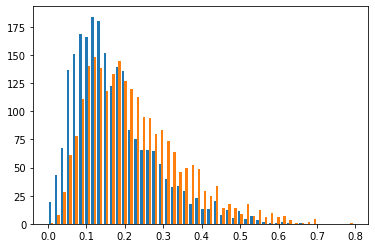

In [165]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['cv_plotsyn_revtxt'],
         df_reviews[df_reviews.is_spoiler == 1]['cv_plotsyn_revtxt']], bins=50);

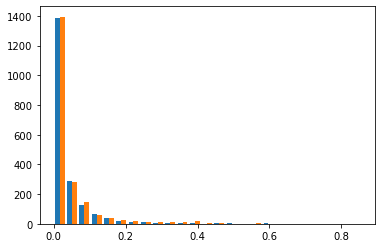

In [167]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['cv_plotsyn_revsum'],
         df_reviews[df_reviews.is_spoiler == 1]['cv_plotsyn_revsum']], bins=25);

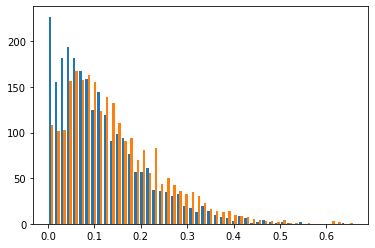

In [168]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['cv_plotsum_revtxt'],
         df_reviews[df_reviews.is_spoiler == 1]['cv_plotsum_revtxt']], bins=50);

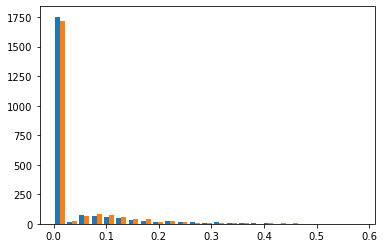

In [170]:
plt.hist([df_reviews[df_reviews.is_spoiler == 0]['cv_plotsum_revsum'],
         df_reviews[df_reviews.is_spoiler == 1]['cv_plotsum_revsum']], bins=25);

## Using SpaCy

We will use SpaCy to find if there are better results that can use to distinguished between spoilers and not spoiler reviews.

In [88]:
nlp = spacy.load('en_core_web_md')
spacy_plotsyn_revtxt = []
spacy_plotsyn_revsum = []
spacy_plotsum_revtxt = []
spacy_plotsum_revsum = []

for idx in df_reviews.index:
    
    mov_ID = df_reviews['movie_id'].iloc[idx]
    revtxt = df_reviews['review_text'].iloc[idx]
    revsum = df_reviews['review_summary'].iloc[idx]

    plot_syn = nlp(df_details[df_details.movie_id == mov_ID]['plot_synopsis'].values[0])
    plot_sum = nlp(df_details[df_details.movie_id == mov_ID]['plot_summary'].values[0])
    rev_txt = nlp(revtxt)
    rev_sum = nlp(revsum)
    
    spacy_plotsyn_revtxt.append(plot_syn.similarity(rev_txt))
    spacy_plotsyn_revsum.append(plot_syn.similarity(rev_sum))
    spacy_plotsum_revtxt.append(plot_sum.similarity(rev_txt))
    spacy_plotsum_revsum.append(plot_sum.similarity(rev_sum))
    

df_reviews['spacy_plotsyn_revtxt'] = spacy_plotsyn_revtxt
df_reviews['spacy_plotsyn_revsum'] = spacy_plotsyn_revsum
df_reviews['spacy_plotsum_revtxt'] = spacy_plotsum_revtxt
df_reviews['spacy_plotsum_revsum'] = spacy_plotsum_revsum

<ipython-input-88-cd9dc5c34ecc>:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  spacy_plotsyn_revtxt.append(plot_syn.similarity(rev_txt))
<ipython-input-88-cd9dc5c34ecc>:19: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  spacy_plotsyn_revsum.append(plot_syn.similarity(rev_sum))
<ipython-input-88-cd9dc5c34ecc>:21: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  spacy_plotsum_revsum.append(plot_sum.similarity(rev_sum))


In [ ]:
df_reviews.to_json('/content/drive/MyDrive/df_reviews.json')

In [ ]:
df_reviews = pd.read_json('/content/drive/MyDrive/df_reviews.json')

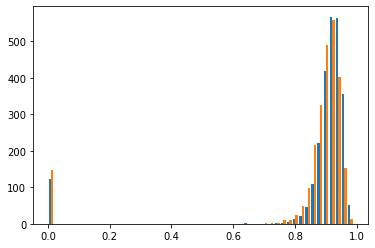

In [89]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsyn_revtxt'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsyn_revtxt']], bins=50);

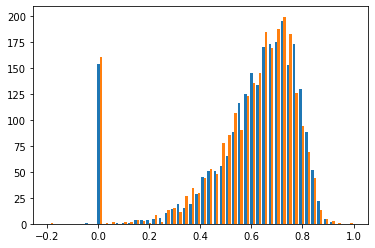

In [90]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsyn_revsum'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsyn_revsum']], bins=50);

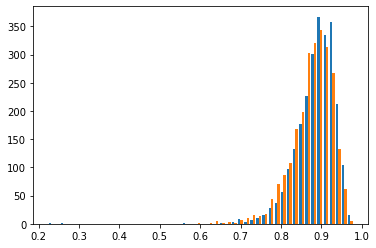

In [91]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsum_revtxt'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsum_revtxt']], bins=50);

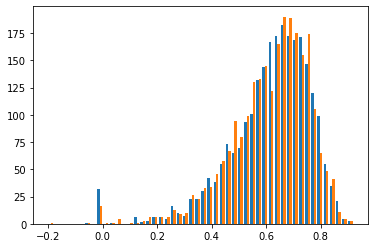

In [92]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsum_revsum'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsum_revsum']], bins=50);

## Using doc2vec

We will try Doc2Vec to find if there are good results or not.

In [93]:
dataset = api.load('text8')
data = [d for d in dataset]

[==================================================] 100.0% 31.6/31.6MB downloaded


In [94]:
df_reviews.head(2)

,movie_id,user_id,is_spoiler,review_text,review_summary,tfidf_plotsyn_revtxt,tfidf_plotsyn_revsum,tfidf_plotsum_revtxt,tfidf_plotsum_revsum,cv_plotsyn_revtxt,cv_plotsyn_revsum,cv_plotsum_revtxt,cv_plotsum_revsum,spacy_plotsyn_revtxt,spacy_plotsyn_revsum,spacy_plotsum_revtxt,spacy_plotsum_revsum
0,tt0251127,ur5118137,1,wait movie come video although sound somewhat ...,couldnt believe actually like movie,0.00000,0.000000,0.045928,0.00000,NaN,NaN,0.074953,0.000000,0.000000,0.00000,0.881856,0.811880
1,tt0108399,ur3712755,1,like true romance story cool funny scene make ...,fun watch possible spoiler,0.14083,0.011572,0.285808,0.11323,0.175745,0.026162,0.294937,0.113228,0.897208,0.66975,0.896404,0.692687


In [95]:
df_details.head(2)

,movie_id,plot_summary,plot_synopsis
0,tt0105112,former cia analyst jack ryan england family va...,jack ryan ford work vacation london family ret...
1,tt1204975,billy michael douglas paddy robert de niro arc...,four boy around age friend brooklyn nickname f...


In [96]:
def taged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(taged_document(data))

In [97]:
model=gensim.models.doc2vec.Doc2Vec(vector_size = 100, min_count=2, epochs=30)
model.build_vocab(data_for_training)

In [98]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [99]:
rev_sim = []
for i in range(df_reviews.shape[0]):
    mov_ID = df_reviews.iloc[i]['movie_id']
    x = model.similarity_unseen_docs(df_details[df_details.movie_id == mov_ID]['plot_synopsis'].values[0].split(),
                                     df_reviews.iloc[i]['review_text'].split())
    rev_sim.append(x)

In [100]:
df_reviews['doc2vec_sim'] = rev_sim

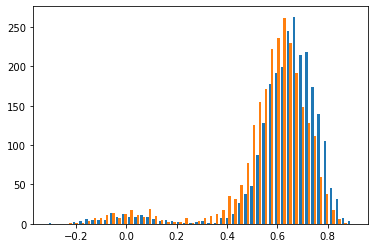

In [101]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['doc2vec_sim'], 
          df_reviews[df_reviews.is_spoiler == 0]['doc2vec_sim']], bins=50);

## Clustering (on review_text)

In [5]:
def clean_text(text, tokenizer, stopwords):
    text = str(text).lower()                     # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)        # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)             # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)           # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )                                            # Remove punctuation
    tokens = tokenizer(text)                            # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens] # Remove digits
    tokens = [t for t in tokens if len(t) > 1]          # Remove short tokens
    return tokens

In [6]:
def vectorize(list_of_docs, model):
    features = []
    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(list(avg_vec))
        else:
            features.append(list(zero_vector))
    return features

In [7]:
corpus_text = 'n'.join(df_reviews[:2000]['review_text'])
len(corpus_text)
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

In [8]:
model = gensim.models.Word2Vec(data, min_count = 1, window = 5, sg = 1)
model.wv.most_similar("movie")

[('film', 0.8827634453773499),
 ('movie.nthis', 0.8566009998321533),
 ('movie.the', 0.8303665518760681),
 ('definite', 0.8284518718719482),
 ('cause', 0.8211185932159424),
 ('thoroughly', 0.8189827799797058),
 ('summary', 0.8187723159790039),
 ('nit', 0.8133601546287537),
 ('enjoyed', 0.8109321594238281),
 ('defiantly', 0.8074262142181396)]

In [1]:
custom_stopwords = set(stopwords.words("english") + ["movie","film", "write"]) # we added the most common words
df = df_reviews.copy()
df["tokens"] = df["review_text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["review_text", "tokens"]]

print(f"Original dataframe: {df_reviews.shape}")
print(f"Pre-processed dataframe: {df.shape}")

In [ ]:
vectorized_docs = vectorize(data, model=model)
len(vectorized_docs), len(vectorized_docs[0])

In [ ]:
sse = []
Sil_coefs = []
list_k = list(range(2, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(vectorized_docs)
    sse.append(km.inertia_)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(vectorized_docs, labels, metric='euclidean'))


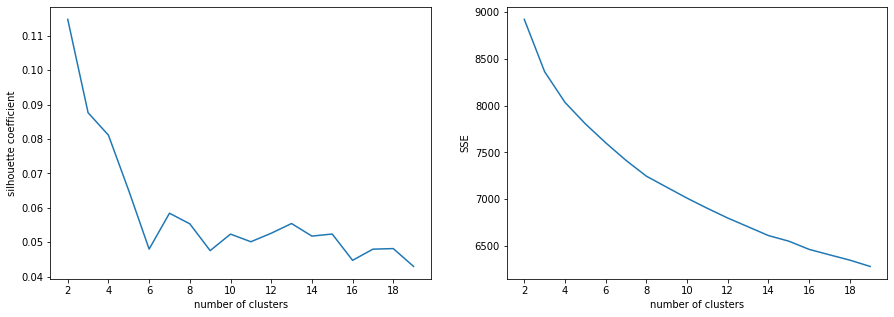

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2))

# plot Intertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

# Recommender, Web App and API.

The recommendation code can be found in the Movies_Recommender_App.ipynb file together with the web app and API.

# Extra Work

## Topic Modeling

We tried topic modeling but we didn't obtain good results that can be used in our project.

### Clustering without LDA (on plot_summary) to get genres.

In [ ]:
custom_stopwords = set(stopwords.words("english") + ["movie","film", "write"]) # we sould see what are the most common words
df = df_details.copy()
df["tokens"] = df["plot_summary"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["plot_summary", "tokens"]]

print(f"Original dataframe: {df_reviews.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (5000, 18)
Pre-processed dataframe: (1572, 2)


In [ ]:
corpus_text = 'n'.join(df_details['plot_summary'])
len(corpus_text)
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

In [ ]:
model = gensim.models.Word2Vec(data, min_count = 1, window = 5, sg = 1)

In [ ]:
vectorized_docs = vectorize(data, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(1, 100)

In [ ]:
sse = []
Sil_coefs = []
list_k = list(range(2, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(vectorized_docs)
    sse.append(km.inertia_)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(vectorized_docs, labels, metric='euclidean'))

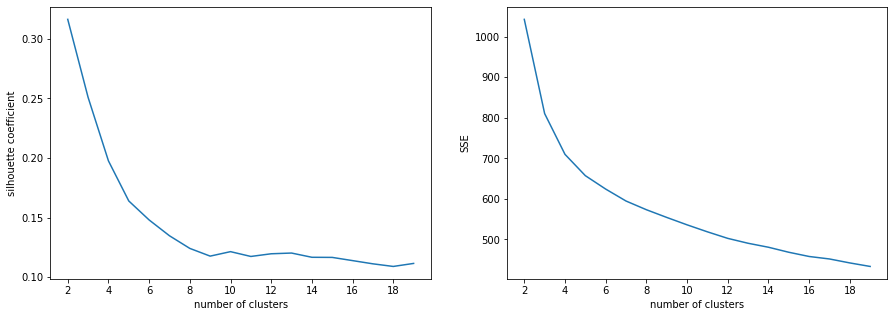

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2))

# plot Intertia/SSE on ax2
ax2.plot(k_clusters, sse)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

### Using LDA

The number of topics we have is 20 topic (genres) based on domain knowledge about the dataset.

In [72]:
vectorizer = TfidfVectorizer(decode_error='ignore')

In [73]:
doc_word = vectorizer.fit_transform(df_details.plot_summary).transpose()

In [74]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

In [75]:
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

In [76]:
# Do the Grid Search
model.fit(doc_word)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [77]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_word))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -27676.37125538759
Model Perplexity:  19988.175963923415


In [90]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_word)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(range(17130)))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.080000,0.080000,0.200000,0.080000,0.170000,0.080000,0.080000,0.080000,0.080000,0.080000,2
Doc1,0.030000,0.030000,0.030000,0.030000,0.030000,0.720000,0.030000,0.030000,0.030000,0.030000,5
Doc2,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.060000,0.240000,0.060000,0.240000,7
Doc3,0.080000,0.260000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,1
Doc4,0.030000,0.030000,0.030000,0.030000,0.030000,0.690000,0.030000,0.030000,0.030000,0.030000,5
Doc5,0.040000,0.040000,0.040000,0.040000,0.040000,0.620000,0.040000,0.040000,0.040000,0.040000,5
Doc6,0.080000,0.250000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,1
Doc7,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.250000,0.080000,0.080000,0.080000,6
Doc8,0.080000,0.080000,0.150000,0.080000,0.080000,0.210000,0.080000,0.080000,0.080000,0.080000,5
Doc9,0.060000,0.060000,0.060000,0.060000,0.060000,0.480000,0.060000,0.060000,0.060000,0.060000,5


In [81]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,4703
1,8,1542
2,4,1512
3,6,1429
4,0,1395
5,9,1355
6,2,1339
7,1,1306
8,7,1301
9,3,1248


In [ ]:
# !pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_word, vectorizer, mds='tsne')
panel

In [ ]:
df_topic_keywords

In [84]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_output, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=100)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,...,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81,Word 82,Word 83,Word 84,Word 85,Word 86,Word 87,Word 88,Word 89,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99
Topic 0,babylon,20th,150,adulterous,agatha,anonymous,aol,arraignment,admired,1752,arrangements,allison,balthazar,adrenaline,battle,as9401k56,aim,baptist,adolescent,advance,a24,america,assistant,aliens,barnett,answers,barada,beckett,adolescence,ark,awful,bardem,abducts,bedtime,auto,bargains,atmospheric,11th,advised,archer,...,anaya,appeals,aristede,avenger,65th,ambulance,54,backup,anxious,amassing,awol,arroway,accomplished,baggage,amateur,aslan,backstage,angeles,airship,bannock,basically,baltimore,ago,2031,alzheimer,basts,appropriate,argentinian,2011,alley,affordable,aj_lum,56,aniston,1980,97fa043,andie,anaconda,attacked,appearing
Topic 1,auguste,approve,andrewhodkinson,beau,awakened,auschwitz,32,baldwin,aliw135,4th,1981,absolutely,albl,balance,64,an,against,abnormally,1950,bandy,acheron,african,barker,baptiste,attila,backward,balmoral,assassinate,alfiehitchie,assimilate,1980s,antoinette,addresses,ashtray,alive,abortions,assimilates,abduct,assigned,24th,...,aged,1941,agustin,1000,awakening,19,audit,ashburn,awarding,27th,action,131,alec,aladeen,accidently,alinga,after,ambrose,are,afoul,ads,1903,allies,awaiting,acquisitions,android,astronaut,amityville,applies,awake,arctic,1839,athens,addiction,bars,attacker,affairs,480,achilles,animosity
Topic 2,1823,annabelle,articulate,barriers,acquire,arm,bake,asajj,altered,again,audition,base,1874,1st,aether,aburner,barely,barons,afforded,acquaintance,assertive,170,accommodate,ann,attorneys,alzheimers,arabs,adult,afternoon,arrested,armour,assembling,amelia,angier,bedridden,angelo,alpha,ahead,1960,1849,...,arbitrary,batman,33,36,ball,161,assortment,average,amusing,arrival,allie,alfalfa,alcatraz,arcade,amélie,aames,200,army,affections,1431,axel,1954,aired,avatar,battling,absolute,amber,archangel,abundant,adventures,bail,along,1966,bar,agenda,beaufort,abraham,accomplices,aboard,augustus
Topic 3,additional,amira,1863,beens,announcement,assembled,2003,angel,beane,assess,bandersnatches,apocalypse,addition,achieved,alienation,10th,aurora,administrator,assigning,acquires,anduin,autonomy,amy,adoration,1987,abernathy,arisen,arises,admiral,arranges,bat,baby,ambushes,arks,attorney,1982,appreciated,anton,1920s,bare,...,alan,backwoods,annals,agnes,administration,avatars,alfredo,1805,att,2017,beard,bauers,alonzo,assertion,backseat,1976,amanda,andreww,apprehend,airport,007,arkansas,apartment,appreciate,attinger,arabia,aviation,any,anxiously,1993,bee,barbed,beanie,advocating,armed,1860s,bandits,abuses,baldinotto,abducting
Topic 4,anubis,around,assist,barrymore,bathtub,alicia,allspark,baddest,altogether,annihilation,25,attending,becky,babita,bear,47,appoints,baptie,alienates,backhouse,ado,bedridge,areas,abode,basis,15,adaptation,ashamed,avi,alike,250,bearing,aslam,beautifully,athletic,accommodating,anglerfish,battalion,authority,abba,...,audio,amphibian,1991,babies,1983,adelie,aussi,aquaman,agree,ayatollah,2009,anomaly,beams,1927,aciman,ability,abruptly,1988,admirer,19th,baca,ally,50s,alligator,500,am,assigns,antidote,1800s,array,30th,access,2054,apology,astound,anthology,65,baronial,accept,2029
Topic 5,angels,basket,assuming,ascent,abhijat,00,apologize,accounting,1868,adèle,60s,asneeze,2139,admitting,3po,beatrice,awaking,alienated,animation,actualization,astronauts,baran,address,athos,baskin,75,add,beca,assembly,arduous,actress,anuja,aircraft,agnew,arrows,announce,bateman,18,angers,bar

In [85]:
# Construct the k-means clusters
from sklearn.cluster import KMeans

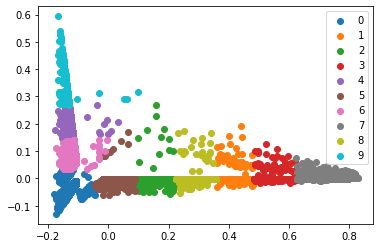

In [86]:
#using PCA with K mean
from sklearn.decomposition import PCA
pca = PCA(2)
df = pca.fit_transform(lda_output)
kmeans = KMeans(n_clusters= 10)
label = kmeans.fit_predict(df)
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [87]:
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.22  0.22  0.22  0.22  0.23  0.74  0.23  0.22  0.24  0.23]
 [-0.24 -0.24 -0.24 -0.24 -0.25  0.68 -0.25 -0.24 -0.25 -0.25]]
Perc of Variance Explained: 
 [0.16 0.54]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

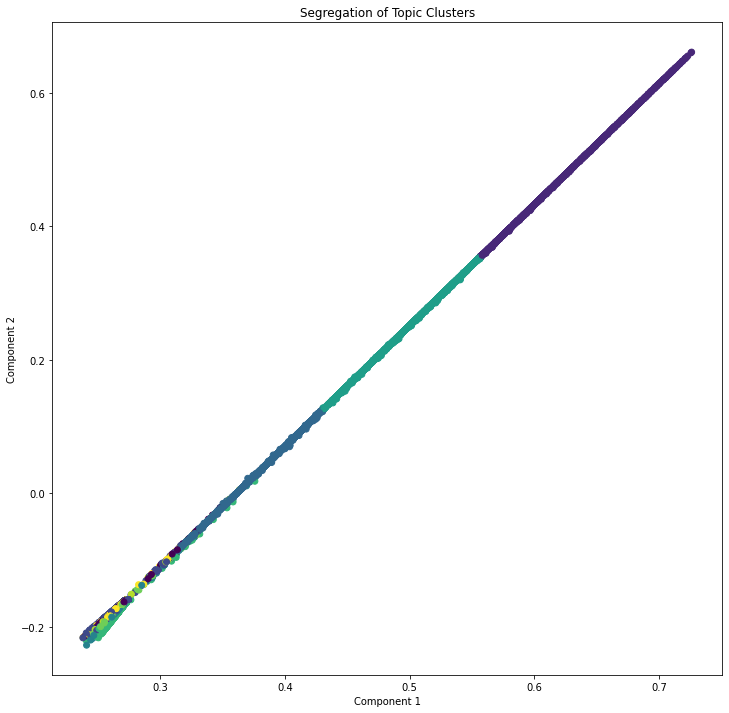

In [88]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )